# Project Power

This htb chall is dear to my heart as it is about correlation power analysis. We are given a remote server, which we can attach to, provide a plaintext, and retrieve the measured power trace from the device. I tried two different tools on this challenge and, while I had problems with `jlsca`, `lascar` worked like a breeze and I will present that solution here. The `jlsca` non-solution is also added to the repo, so if anybody ever finds a way to make it work - please tell me! I need to know!

## Gathering traces

The first part is basically given. It's a bit of copy pasting and then we can store away the traces and plaintexts in npy files. It basically looks as follows - the actual code can be found in `gathertraces.py`

In [ ]:
import time
import numpy as np
import socket
import base64
import tqdm

HOST = "replace_ip" 
PORT = 0 # replaceport 

def b64_decode_trace(leakage):
        byte_data = base64.b64decode(leakage) # decode base64
        return np.frombuffer(byte_data) # convert binary data into a NumPy array

def connect_to_socket(option, data):
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
                s.connect((HOST, PORT))
                resp_1 = s.recv(1024)
                s.sendall(option)
                resp_2 = s.recv(1024)
                s.sendall(data)
                resp_data = b''
                while True:
                        temp_data = s.recv(8096)
                        if not temp_data:
                                break
                        resp_data += temp_data
                s.close()

                return resp_data

values = []
traces = []

for i in tqdm.tqdm(range(1000)):
    value = np.random.randint(0, 256, (16,), dtype=np.uint8)
    plaintext = value.tobytes()

    leakage = connect_to_socket(b'1', plaintext)
    trace = b64_decode_trace(leakage)

    if (len(trace) == 0):
        break

    values.append(value)
    traces.append(trace)
    time.sleep(0.1)

values = np.array(values)
traces = np.array(traces)

np.save("traces.npy", traces)
np.save("pts.npy", values)


## Attacking the power traces

Now for the interesting part. I will not go too deep into the theory of CPA, a simple to understand explanation can be found on the `chipwhisperer` website at http://wiki.newae.com/Correlation_Power_Analysis

The basic idea is: Computation needs power. Measurements of power consumption over time thus gives information about what kind of computation has been executed. If enough of the same computations are executed while gathering these measurements, we can carefully place these measurements (also called traces) on top of each other and analyze the correlation with a key-hypothesis we hold. The expectation is that a computation that results in a lot of toggled bits consumes more power than a computation that toggles less bits.

As we know that the used algorithm is AES, and we know that it must be a chosen-plaintext attack (Because we only have the plaintext and the traces), we know that we will need to attack the first round of AES - namely, the first sub-box of AES.

The sub-box in AES replaces a byte with another byte. This is a good target for CPA because of two main reasons:

1) The result of the operation only depends on the input byte, not on any other bytes of the state matrix.
2) A single bit swapped in the input byte will create a big difference in the output value (much like a good hashing function). This means that the correlation attack can well distinguish between similar input bytes. This is in stark contrast to something like a simple XOR. Here, a single bit change will result in at most a single bit change in the output value.

Equipped with this knowledge, lets script a simple lascar script and see what we get

/home/kali/.local/lib/python3.11/site-packages/lascar-0.1-py3.11.egg/lascar/output/output_method.py:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/kali/.local/lib/python3.11/site-packages/lascar-0.1-py3.11.egg/lascar/output/output_method.py:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
2024-07-22 21:30:18,702 - lascar.session - INFO - Session Session: 986 traces, 18 engines, batch_size=100, leakage_shape=(1042,)
Session |100%||986 trc/986 | (18 engines, batch_size=100, leakage_shape=(1042,)) |Time:  0:00:0500


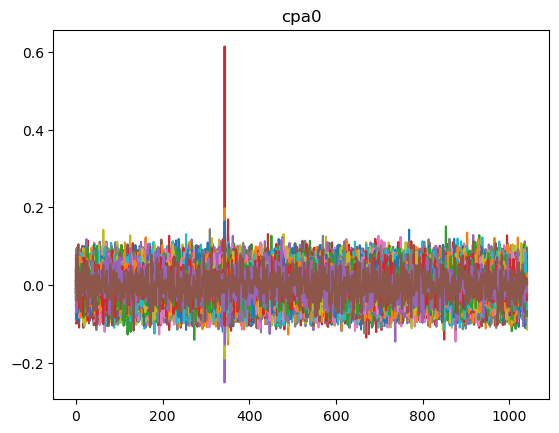

In [3]:
import numpy as np 
from lascar import Session, CpaEngine, ConsoleOutputMethod, MatPlotLibOutputMethod, RankProgressionOutputMethod, ScoreProgressionOutputMethod, DictOutputMethod
from lascar.container import TraceBatchContainer
from lascar.tools.aes import sbox

traces = np.load("traces.npy")
values = np.load("pts.npy")


engines = [
        CpaEngine(f"cpa{i}",  lambda v, k, z=i: sbox[v[z] ^ k], range(256))
        for i in range(16)
]


t = TraceBatchContainer(traces, values)
s = Session(t)
s.add_engines(engines)
s.output_method = MatPlotLibOutputMethod(engines[0])

s.run()



## Results

We only plotted above the outputs of a single byte. This needs to be repeated for all the 16 bytes of the key. What we see is that for one of the keybyte-hypothesis, the power traces highly correlate with the keybyte hypothesis at around sample 350. We can use a different output method to see the entire key:

In [6]:
s.output_method = ConsoleOutputMethod()

s.run()

2024-07-22 21:33:42,782 - lascar.session - INFO - Session Session: 986 traces, 18 engines, batch_size=100, leakage_shape=(1042,)
Session | 91%||900 trc/986 | (18 engines, batch_size=100, leakage_shape=(1042,)) |ETA:   0:00:002024-07-22 21:33:43,598 - lascar.output.output_method - INFO - Results: mean with 986 traces:  [(-0.06954782097942833, 20.062024827977414, 5.49910468980755, 38.122364363820154)]
2024-07-22 21:33:43,599 - lascar.output.output_method - INFO - Results: var with 986 traces:  [(0.8903899232254062, 20.831197672393074, 4.012042944308009, 38.0578491059504)]
2024-07-22 21:33:43,605 - lascar.output.output_method - INFO - Results: cpa0 with 986 traces: [35] 0.61 (rank 1) - [72] 0.25 (rank 2) - [97] 0.20 (rank 3)
2024-07-22 21:33:43,612 - lascar.output.output_method - INFO - Results: cpa1 with 986 traces: [42] 0.59 (rank 1) - [0f] 0.24 (rank 2) - [91] 0.19 (rank 3)
2024-07-22 21:33:43,622 - lascar.output.output_method - INFO - Results: cpa2 with 986 traces: [52] 0.57 (rank 1) 

We can then plug together the key bytes with rank 1 and receive the key:

35425203f4bf23c7f93444bf772f2e1f